<a href="https://colab.research.google.com/github/enscully/AWS_Geospatial/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthengine-api --upgrade -q
!pip install eemont geemap -q

In [2]:
import eemont
import geemap
import pandas as pd
import numpy as np

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()
print(ee.Image("NASA/NASADEM_HGT/001").get("title").getInfo())

In [68]:
roi = ee.Geometry.Point([-114.762293, 36.06462])

In [89]:
images = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(roi)
    .filterDate('2010-01-01', '2023-12-31')
    # .maskClouds() # Makes clouds empty pixels
    # .sort('CLOUD_COVER')
)

images = images.filter(ee.Filter.lessThan('CLOUD_COVER', 5))

In [90]:
print(images.size().getInfo())

115


In [91]:
listOfImages = images.toList(images.size()) # Another way to get the first image, but can get any image
lastImage = ee.Image(listOfImages.get(len(listOfImages)-1))
lastImage

In [92]:
# input = ee.Image('LANDSAT/LE7_TOA_1YEAR/2001')
# input = images.first()
input = lastImage

region = ee.Geometry.Rectangle(-114.080428, 36.002173, -114.838485, 36.458568)
Map = geemap.Map()

Map.setCenter(lon = -114.762293, lat = 36.06462, zoom = 8)

vis_params = {
    "bands": ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0,
    'max': 35000,
    # 'gamma': 1.4,
}
Map.addLayer(input, vis_params, 'Best image')


Map.addLayer(ee.Image().paint(region, 0, 2), {}, 'region')
Map

Map(center=[36.06462, -114.762293], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [93]:
training = input.sample(
  region = region,
  scale = 30,
  numPixels = 5000
)

clusterer = ee.Clusterer.wekaKMeans(10).train(training)

result = input.cluster(clusterer)

In [94]:
# input = ee.Image('LANDSAT/LE7_TOA_1YEAR/2001')
# input = images.first()
input = lastImage

region = ee.Geometry.Rectangle(-114.080428, 36.002173, -114.838485, 36.458568)
Map = geemap.Map()

Map.setCenter(lon = -114.762293, lat = 36.06462, zoom = 8)

vis_params = {
    "bands": ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0,
    'max': 35000,
    # 'gamma': 1.4,
}
Map.addLayer(input, vis_params, 'Best image')


Map.addLayer(ee.Image().paint(region, 0, 2), {}, 'region')
Map.addLayer(result.randomVisualizer(), {}, 'clusters')
Map

Map(center=[36.06462, -114.762293], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [86]:
import seaborn as sns
pal = sns.color_palette("tab10")

In [184]:
legend_keys = ['One', 'Two', 'Three', 'Four', 'Five', "Six", "Seven", "Eight", "Nine", "Ten"]
legend_colors = pal.as_hex()

input = lastImage

input = ee.Image(listOfImages.get(0))

training = input.sample(
  region = region,
  scale = 30,
  numPixels = 5000
)

clusterer = ee.Clusterer.wekaKMeans(10).train(training)

result = input.cluster(clusterer)


region = ee.Geometry.Rectangle(-114.080428, 36.002173, -114.838485, 36.458568)
Map = geemap.Map()

Map.setCenter(lon = -114.762293, lat = 36.06462, zoom = 8)

Map.addLayer(input, vis_params, 'Best image')

Map.addLayer(ee.Image().paint(region, 0, 2), {}, 'region')
Map.addLayer(result.randomVisualizer(), {}, 'clusters')

Map.addLayer(
    result, {'min': 0, 'max': 9, 'palette': legend_colors}, 'Labelled clusters'
)
Map.add_legend(
  position='bottomright', legend_dict = dict(zip(legend_keys, legend_colors))
)

In [185]:
Map

Map(center=[36.06462, -114.762293], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [56]:
Map.addLayer(result.eq(8 + 1).randomVisualizer(), {}, 'water')
Map

In [ ]:
# water_image = result.eq(8 + 1).selfMask()
# Map.addLayer(water_image, {'palette': 'blue'}, 'Water image')
# Map

In [95]:
areaImage = ee.Image.pixelArea().addBands(result)

In [58]:
Map.addLayer(region, {}, 'rectangleBounds')

In [96]:
areas = areaImage.reduceRegion(
      reducer = ee.Reducer.sum().group(
      groupField = 1,
      groupName = 'class',
    ),
    geometry = region,
    scale = 500,
    maxPixels = 1e10
    )

In [97]:
classAreas = ee.List(areas.get('groups')).getInfo()
area_df = pd.DataFrame(classAreas)

# Finds km^2 for each group
area_df["sum"] = area_df["sum"].divide(1e6).round()

In [98]:
area_df

,class,sum
0,0,360.0
1,1,220.0
2,2,477.0
3,3,303.0
4,4,148.0
5,5,253.0
6,6,344.0
7,7,501.0
8,8,552.0
9,9,293.0


In [99]:
input

In [ ]:
del area_df
for i in range(0, len(listOfImages)):
  input = ee.Image(listOfImages.get(i))

  training = input.sample(
    region = region,
    scale = 30,
    numPixels = 5000
  )

  clusterer = ee.Clusterer.wekaKMeans(10).train(training)

  result = input.cluster(clusterer)

  areaImage = ee.Image.pixelArea().addBands(result)

  areas = areaImage.reduceRegion(
        reducer = ee.Reducer.sum().group(
        groupField = 1,
        groupName = 'class',
      ),
      geometry = region,
      scale = 500,
      maxPixels = 1e10
      )

  classAreas = ee.List(areas.get('groups')).getInfo()
  area_df_temp = pd.DataFrame(classAreas).rename(columns = {"sum": f"sum_{i}"})

  # Finds km^2 for each group
  area_df_temp[f"sum_{i}"] = area_df_temp[f"sum_{i}"].divide(1e6).round()

  if i == 0:
    area_df = area_df_temp
  else:
    area_df = pd.concat([area_df, area_df_temp], axis=1)
  
  print(i)

In [101]:
area_df

,class,sum_0,class,sum_1,class,sum_2,class,sum_3,class,sum_4,...,class,sum_110,class,sum_111,class,sum_112,class,sum_113,class,sum_114
0,0,578.0,0,488.0,0,501.0,0,466.0,0,450.0,...,0,509.0,0,277.0,0,201.0,0,424.0,0,360.0
1,1,259.0,1,332.0,1,302.0,1,231.0,1,547.0,...,1,297.0,1,235.0,1,138.0,1,129.0,1,220.0
2,2,414.0,2,398.0,2,400.0,2,586.0,2,489.0,...,2,454.0,2,595.0,2,366.0,2,611.0,2,477.0
3,3,124.0,3,452.0,3,436.0,3,355.0,3,216.0,...,3,150.0,3,311.0,3,729.0,3,385.0,3,303.0
4,4,171.0,4,112.0,4,93.0,4,87.0,4,74.0,...,4,127.0,4,123.0,4,123.0,4,127.0,4,148.0
5,5,270.0,5,244.0,5,239.0,5,262.0,5,233.0,...,5,395.0,5,293.0,5,415.0,5,396.0,5,253.0
6,6,467.0,6,517.0,6,533.0,6,578.0,6,103.0,...,6,382.0,6,450.0,6,284.0,6,560.0,6,344.0
7,7,420.0,7,318.0,7,336.0,7,446.0,7,505.0,...,7,402.0,7,782.0,7,516.0,7,336.0,7,501.0
8,8,380.0,8,230.0,8,260.0,8,83.0,8,487.0,...,8,454.0,8,94.0,8,396.0,8,198.0,8,552.0
9,9,368.0,9,360.0,9,351.0,9,357.0,9,347.0,...,9,281.0,9,291.0,9,284.0,9,286.0,9,293.0


In [182]:
Map = geemap.Map()

Map.setCenter(lon = -114.762293, lat = 36.06462, zoom = 8)

Map.addLayer(ee.Image(listOfImages.get(0)), vis_params, 'Best image')

Map.addLayer(ee.Image().paint(region, 0, 2), {}, 'region')

legend_keys = ['One', 'Two', 'Three', 'Four', 'Five', "Six", "Seven", "Eight", "Nine", "Ten"]
legend_colors = pal.as_hex()

Map.addLayer(
    result, {'min': 0, 'max': 9, 'palette': legend_colors}, 'Labelled clusters'
)
Map.add_legend(
  position='bottomright', legend_dict = dict(zip(legend_keys, legend_colors))
)
Map

Map(center=[36.06462, -114.762293], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [103]:
import seaborn as sns

In [132]:
area_df = pd.concat([area_df.iloc[:,0], area_df.filter(regex = "sum")], axis = 1)

In [133]:
long_df = area_df.loc[area_df["class"] == 9, ].T.drop("class").reset_index(drop = True)
long_df = long_df.rename(columns = {9: "area"})
long_df['area'] = pd.to_numeric(long_df['area'], errors='coerce')
long_df['keep'] = (long_df.diff().abs() < 50).astype(int)

In [134]:
long_df.keep.sum()

97

<Axes: ylabel='area'>

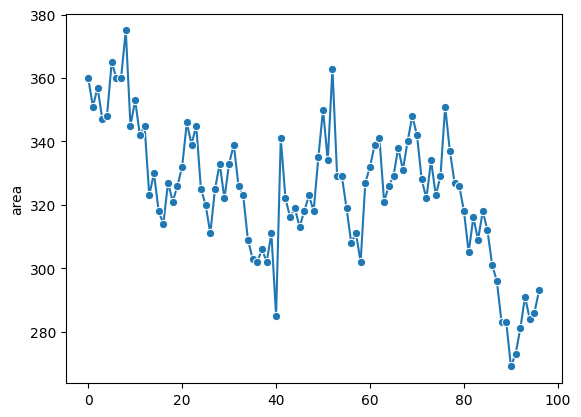

In [135]:
sns.lineplot(long_df.loc[long_df["keep"] == 1, ], x = range(0, long_df['keep'].sum()), y = "area", marker = "o")

In [ ]:
print(long_df.to_string())

In [175]:
dates = list()
for i in range(0, len(listOfImages)):
  dates.append(ee.Image(listOfImages.get(i)).date().format('MM-dd-yyyy').getInfo())

In [ ]:
dates

In [177]:
long_df["Date"] = dates
long_df["Date"] = pd.to_datetime(long_df["Date"], format = '%m-%d-%Y')

In [ ]:
long_df

<Axes: xlabel='Date', ylabel='area'>

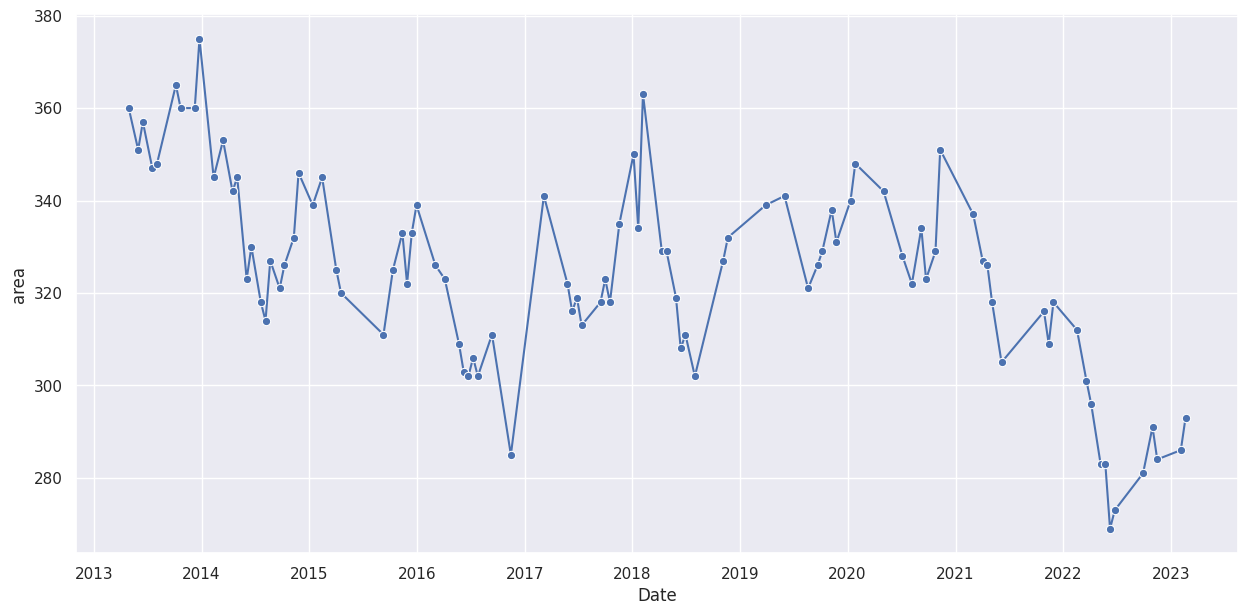

In [181]:
sns.set(rc={'figure.figsize':(15,7)})
sns.lineplot(long_df.loc[long_df["keep"] == 1, ], x = "Date", y = "area", marker = "o")